In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PDE.utils import *
import drjit as dr
from PDE import Float,Point2f, PCG32, UInt, Bool, ArrayXf
from PDE.BoundaryShape import QuadraticBezierShape
from PDE.Coefficient import ConstantCoefficient
from PDE.BoundaryShape.interaction import *

In [2]:
points = create_circle_points(radius = 1, resolution =3, spp = 1, discrete_points = True, centered = False)
normals = dr.normalize(points)
dirichlet_map = [True, False, False]
shape = QuadraticBezierShape(points.numpy(), normals.numpy(), dirichlet = [ConstantCoefficient("dirichlet", 0)], 
                             neumann = [ConstantCoefficient("neumann", 0)],
                             dirichlet_map = dirichlet_map, n_segment = 5, newton_steps = 5)

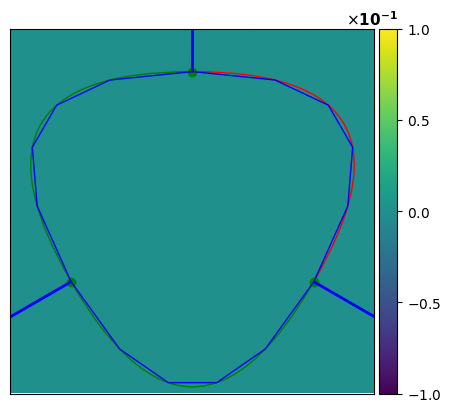

In [3]:
s = 1.3
bbox = [[-s, -s], [s, s]]
resolution = [512, 512]
image = np.zeros(resolution)

fig, ax = plt.subplots(1,1,figsize = (5,5))
shape.sketch(ax, bbox, resolution)
shape.sketch_points(ax, bbox, resolution, control_points=True)
shape.sketch_normals(ax, bbox, resolution)
shape.sketch_polyline(ax, bbox, resolution)
plot_image(image, ax)

In [4]:
r = 0.8;
origin =Point2f(0.0, 0)
num_points = 8
points = create_circle_points(origin = origin, radius=r, resolution = num_points, spp = 1, discrete_points=True, centered = True)

In [5]:
bi = shape.boundary_interaction(points)

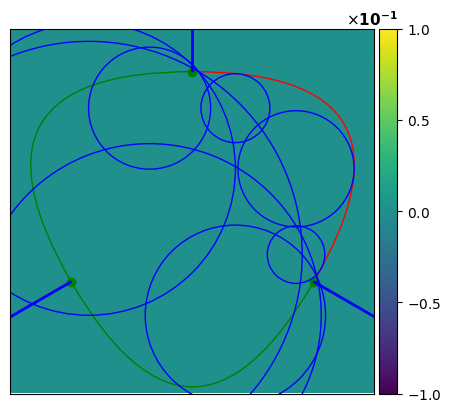

In [6]:
#dist, n, t = shape.get_closest_dist(points)

fig, ax = plt.subplots(1,1,figsize = (5,5))
shape.sketch(ax, bbox, resolution)
shape.sketch_points(ax, bbox, resolution)
shape.sketch_normals(ax, bbox, resolution)

dist_s = dist2sketch(bi.r, bbox, resolution)[0].numpy().squeeze()
points_s = point2sketch(points, bbox, resolution).numpy().squeeze()

for i in range(num_points):
    boundary_circle = plt.Circle(points_s[:,i], radius = dist_s[i], fill=False, color="blue")
    #boundary_circle = plt.Circle(points_s, radius = dist_s, fill=False, color="blue")
    ax.add_patch(boundary_circle)
#shape.sketch_polyline(ax, bbox, resolution, color = 'green')
plot_image(image, ax)

In [7]:
sampler = PCG32(dr.width(points), dr.arange(UInt, dr.width(points)))
points =  2 *Point2f(sampler.next_float32(), sampler.next_float32()) -1
bi = BoundaryInfo(origin = points, on_boundary = Bool(False))
directions = dr.normalize(Array2f(points))
#directions =Point2f(directions[1], -directions[0])
shape.inside = True
ri = shape.ray_intersect(bi, directions)
#ri.intersected = dr.select(dr.isfinite(ri.t), ri.intersected, ri.origin)
#ri.t = dr.select(dr.isfinite(ri.t), ri.t, dr.epsilon(Float))

points_s = point2sketch(points, bbox, resolution).numpy().squeeze()
directions_s = dir2sketch(directions, bbox, resolution).numpy().squeeze()
intersect_s = point2sketch(ri.intersected, bbox, resolution).numpy().squeeze()

In [8]:
ri.intersected

[[-1.14835, 0.230745],
 [inf, inf],
 [-0.941076, 0.783492],
 [0.764678, -0.665268],
 [-0.745453, 0.890828],
 [-0.876144, 0.827387],
 [0.827302, -0.565571],
 [0.971149, 0.758958]]

/home/ekrem/Environments/inv-pde-new/lib/python3.10/site-packages/matplotlib/patches.py:1471: RuntimeWarning: invalid value encountered in scalar divide
  cx = self._dx / distance
/home/ekrem/Environments/inv-pde-new/lib/python3.10/site-packages/matplotlib/patches.py:1472: RuntimeWarning: invalid value encountered in scalar divide
  sx = self._dy / distance


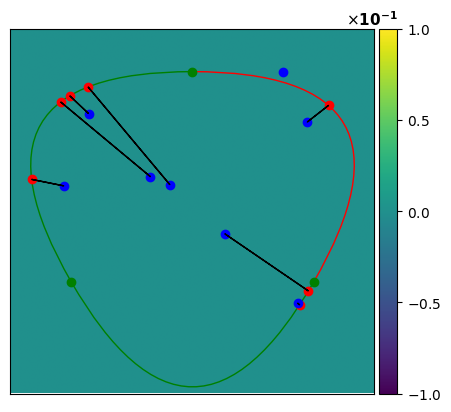

In [9]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image, ax)
shape.sketch(ax, bbox, resolution)
shape.sketch_points(ax, bbox, resolution)
#shape.sketch_normals(ax, bbox, resolution)
ax.scatter(intersect_s[0], intersect_s[1],  color = "red")
ax.scatter(points_s[0], points_s[1], color = "blue")
for i in range(dr.width(points)):
    ax.arrow(points_s[0, i], points_s[1, i], ri.t.numpy()[i] * directions_s[0, i], ri.t.numpy()[i] * directions_s[1, i])

In [10]:
sampler = PCG32(dr.width(points), dr.arange(UInt, dr.width(points)))
t =  Float(sampler.next_float32())
p1, p2, c = shape.get_interpolation_points(0)
points = shape.interpolate(p1, p2, c, t)
bi = shape.boundary_interaction(points)

directions = - dr.normalize(Array2f(points))
#directions =Point2f(-directions[1], directions[0])
ri = shape.ray_intersect(bi, directions)
points_s = point2sketch(points, bbox, resolution).numpy().squeeze()
directions_s = dir2sketch(directions, bbox, resolution).numpy().squeeze()
intersect_s = point2sketch(ri.intersected, bbox, resolution).numpy().squeeze()
print(t)

[0.0406159, 0.821621, 0.349794, 0.875033, 0.419116, 0.129001, 0.615159, 0.909666]


In [11]:
ri.t

[2.24025, 2.19281, 2.22775, 2.20172, 2.24307, 2.20049, 2.23635, 2.2157]

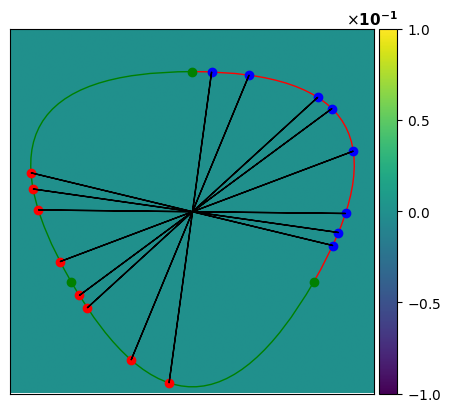

In [12]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image, ax)
shape.sketch(ax, bbox, resolution)
shape.sketch_points(ax, bbox, resolution)
#shape.sketch_normals(ax, bbox, resolution)
ax.scatter(intersect_s[0], intersect_s[1],  color = "red")
ax.scatter(points_s[0], points_s[1], color = "blue")
t_ = np.maximum(0.05, ri.t.numpy())
for i in range(dr.width(points)):
    ax.arrow(points_s[0, i], points_s[1, i], t_[i] * directions_s[0, i], t_[i] * directions_s[1, i])

In [13]:
points = create_image_points(bbox, resolution, spp = 16)
mask = shape.inside_closed_surface_mask(points)
mask_vals = dr.select(mask, 1., 0.)
image, _ = create_image_from_result(mask_vals, resolution)


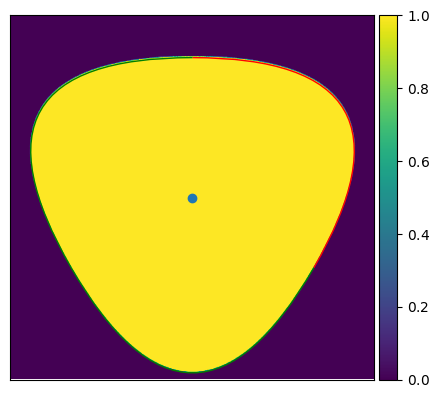

In [14]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image[0], ax)
point_s = point2sketch(shape.bbox_center, bbox, resolution).numpy().squeeze()
ax.scatter(point_s[0], point_s[1])
shape.sketch(ax, bbox, resolution)

In [15]:
num_points = 10
sampler = PCG32(initstate=dr.arange(UInt32,num_points))

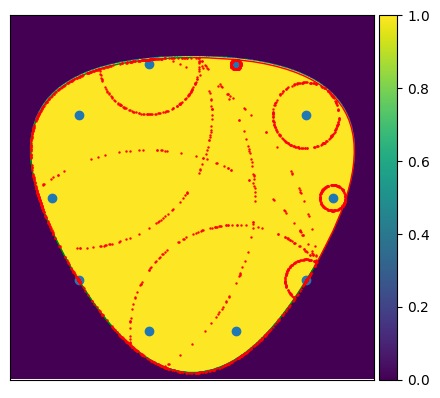

In [16]:
points = create_circle_points(resolution=num_points, spp=1, centered=True, discrete_points=True)
bi = shape.boundary_interaction(points);

fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image[0], ax)
points_s = point2sketch(points, bbox, resolution)
ax.scatter(points_s[0], points_s[1])
shape.sketch(ax, bbox, resolution)

for i in range(200):
    direction, sphere_p, pdf = bi.sample_recursive(sampler.next_float32())
    ri = shape.ray_intersect(bi, direction)
    on_boundary_next = bi.is_star & (ri.t < bi.r)
    points = dr.select(bi.is_star & on_boundary_next, ri.intersected, sphere_p)
    points_s = point2sketch(points, bbox, resolution).numpy()
    ax.scatter(points_s[0], points_s[1], color = "red", s=0.5)

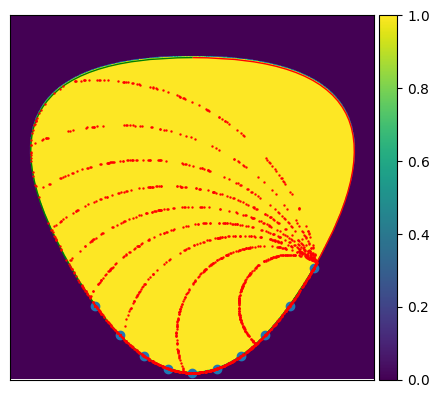

In [17]:
t =  dr.arange(Float, num_points)/num_points
k = 1 
p1, p2, c = shape.get_interpolation_points(k)
points = shape.interpolate(p1, p2, c, t)
bi = shape.boundary_interaction(points);

fig, ax = plt.subplots(1,1,figsize = (5,5))
plot_image(image[0], ax)
points_s = point2sketch(points, bbox, resolution)
ax.scatter(points_s[0], points_s[1])
shape.sketch(ax, bbox, resolution)

for i in range(200):
    direction, sphere_p, pdf = bi.sample_recursive(sampler.next_float32())
    
    ri = shape.ray_intersect(bi, direction)
    on_boundary_next = bi.is_star & (ri.t < bi.r)
    points = dr.select(bi.is_star & on_boundary_next, ri.intersected, sphere_p)
    points_s = point2sketch(points, bbox, resolution).numpy()
    ax.scatter(points_s[0], points_s[1], color = "red", s=0.5)